# COLLECTIVE CLUSTERING

In [1]:
import numpy as np
import datetime
import json
import pylab
import pandas as pd
import matplotlib.pyplot as plt

### Detalles

### Lista de Clientes

In [2]:
# Extraemos la lista de clientes sin repetir

def leer_data():
    outfile='./data/consulta.csv'
    data = pd.read_csv(outfile)
    return data

data = leer_data()
clientes =  data.groupby('client_id').client_id.count().index

## Temporal TXs footprint

In [3]:
# Definimos la ruta de los archivos 

file='U'
raw_data='./data/%s.json' %(file)

individual_footprint="%s.individual_footprint" %(raw_data)

individual_clusters="%s.clusters" %(individual_footprint)
individual_labels="%s.labels" %(individual_footprint)

collective_clusters="%s.collective_footprint.clusters" %(raw_data)
collective_labels="%s.collective_footprint.labels" %(raw_data)

### Funciones

In [4]:
def process_footprint(data,tests,log=False):
    from sklearn.cluster import MiniBatchKMeans
    #KMeans(init='k-means++', n_clusters=k, n_init=10)
    import datetime
    K={}
    for k in tests:
        if k<=len(data):
            if log:
                print("%s: processing %s"%(datetime.datetime.now(),k))
            K[k]=bench_k_means(MiniBatchKMeans(init='k-means++', n_clusters=k, batch_size=100,
                      n_init=10, max_no_improvement=10, verbose=0,
                      random_state=0),name="k-means++", data=data)
    return K

In [5]:
def compute_best_k(x,y,occurrencies, plot=False,points=1000,sf=0.9):
    import numpy as np
    
    if len(x)<5:
        return max(1, round(np.sqrt(occurrencies/2)))
    
    from scipy.interpolate import interp1d
    from scipy.interpolate import UnivariateSpline
    spl = UnivariateSpline(x, y)
    spl.set_smoothing_factor(sf)
    xs = np.linspace(min(x), max(x), points)
    ys = spl(xs)
    idx_better_k=get_change_point(xs, ys)
    if plot:
        import pylab
        pylab.plot(xs,ys)
        
        pylab.scatter(xs[idx_better_k],ys[idx_better_k],s=20, marker='o')
        pylab.text(xs[idx_better_k],ys[idx_better_k],"bestK %s" %(np.round(xs[idx_better_k])))
        return int(np.round(xs[idx_better_k])),pylab
    return int(np.round(xs[idx_better_k]))

In [6]:
def bench_k_means(estimator, name, data,distance_function=None):
    from sklearn import metrics
    from sklearn.metrics import silhouette_samples, silhouette_score
    import time
    t0 = time.time()
    if distance_function:
        estimator.fit(data,distance_function)
    else:
        estimator.fit(data)
    #cluster_labels = estimator.fit_predict(data)
    #silhouette_score_ = silhouette_score(data, cluster_labels)
    
    inertia=estimator.inertia_
    duration=time.time() - t0
    return {'inertia':inertia,'duration':duration, 'estimator':estimator}#,'silhouette':silhouette_score_}

def get_change_point(x, y):
    """
         Elección del mejor K
         :: param x: lista de valores de K
         :: param y: lista de valores de SSE
    """
    import math
    max_d = -float('infinity')
    index = 0

    for i in range(0, len(x)):
        c = closest_point_on_segment(a=[x[0], y[0]], b=[x[len(x)-1], y[len(y)-1]], p=[x[i], y[i]])
        d = math.sqrt((c[0]-x[i])**2 + (c[1]-y[i])**2)
        if d > max_d:
            max_d = d
            index = i
    
    return index

def closest_point_on_segment(a, b, p):
    sx1 = a[0]
    sx2 = b[0]
    sy1 = a[1]
    sy2 = b[1]
    px = p[0]
    py = p[1]

    x_delta = sx2 - sx1
    y_delta = sy2 - sy1

    if x_delta == 0 and y_delta == 0:
        return p

    u = ((px - sx1) * x_delta + (py - sy1) * y_delta) / (x_delta * x_delta + y_delta *  y_delta)
    if u < 0:
        closest_point = a
    elif u > 1:
        closest_point = b
    else:
        cp_x = sx1 + u * x_delta
        cp_y = sy1 + u * y_delta
        closest_point = [cp_x, cp_y]

    return closest_point
	

### Collective clustering

In [7]:
f=open(individual_clusters) #uid,cluster_id,profile
data=[]
for row in f:
    row=row.strip().split(';')
    uid=row[0]
    cluster_id=row[1]
    individual_profile=np.array([float(el) for el in row[2:]])
    data.append(((uid,cluster_id),individual_profile))

to_cluster=[el[1] for el in data]
tests=np.arange(2,50)
tests=list(tests)+list(np.arange(50,150,5))
K=process_footprint(to_cluster,tests,log=True)

import pickle
pickle.dump( K, open( "%s.models.p" %(raw_data), "wb" ) )


2018-08-01 15:08:06.725224: processing 2
2018-08-01 15:08:06.881795: processing 3
2018-08-01 15:08:07.218881: processing 4
2018-08-01 15:08:07.522641: processing 5
2018-08-01 15:08:07.903641: processing 6
2018-08-01 15:08:08.307853: processing 7
2018-08-01 15:08:08.468481: processing 8
2018-08-01 15:08:08.627696: processing 9
2018-08-01 15:08:08.788240: processing 10
2018-08-01 15:08:08.956369: processing 11
2018-08-01 15:08:09.121421: processing 12
2018-08-01 15:08:09.295975: processing 13
2018-08-01 15:08:09.473109: processing 14
2018-08-01 15:08:09.656607: processing 15
2018-08-01 15:08:09.831849: processing 16
2018-08-01 15:08:10.023507: processing 17
2018-08-01 15:08:10.212487: processing 18
2018-08-01 15:08:10.849729: processing 19
2018-08-01 15:08:11.431644: processing 20
2018-08-01 15:08:12.086785: processing 21
2018-08-01 15:08:12.285748: processing 22
2018-08-01 15:08:12.492039: processing 23
2018-08-01 15:08:12.691485: processing 24
2018-08-01 15:08:12.903769: processing 25


### Choose K for global clustering 

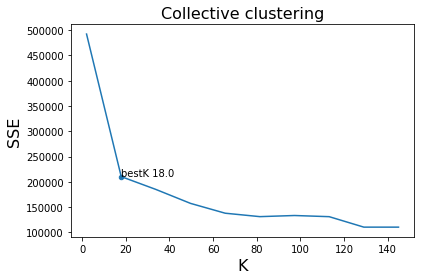

In [8]:
#choose K for global clustering 

%matplotlib inline
x=sorted(K.keys())
y=[K[k]['inertia'] for k in x]
best_k,pylab=compute_best_k(x,y,len(to_cluster),plot=True,points=10)

best_k=18 #a mano
pylab.title("Collective clustering",fontsize=16)
pylab.ylabel("SSE",fontsize=16)
pylab.xlabel("K",fontsize=16)
pylab.tight_layout()
# pylab.savefig('%s.png' %(raw_data),dpi=200)

import pandas as pd
df_sse=pd.DataFrame([x,y]).T
df_sse.columns=['x','y']
#df_sse.to_csv('%s.png.sse.csv' %(raw_data),index=False)

### Exporting results

In [9]:
cluster_centers_=K[best_k]['estimator'].cluster_centers_
labels_=K[best_k]['estimator'].labels_
fw=open(collective_clusters,"w")
fw2=open(collective_labels,"w")
#export individual centroids
for i in np.arange(len(cluster_centers_)):
    string="%s;%s\n"%(i,';'.join([str(el) for el in cluster_centers_[i]])) #cluster_id,centroid
    fw.write(string)
fw.flush()

#export original data and labels
for i in np.arange(len(data)):
    uid=data[i][0]
    profile=data[i][1]
    label=labels_[i]
    string="%s;%s;%s;%s\n" %(uid[0],uid[1],label
                                ,';'.join([str(el) for el in profile]))#uid,individual_cluster_id,collective_cluster_id,profile
    fw2.write(string)
fw2.flush()

print('Done')

Done
